<div class='alert alert-warning' style='font-size:2.3rem; font-weight:500; text-align:center;'>Models for Medical Prognosis<div/>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

import shap

from tqdm.notebook import tqdm

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index as cindex
from lifelines.datasets import load_lymphoma
from lifelines.statistics import logrank_test

In [2]:
np.set_printoptions(suppress=True)
plt.style.use("bmh")
config = {'figure.figsize': (16, 3),
          'axes.titlesize': 18,
          'axes.labelsize': 10,
          'lines.linewidth': 2,
          'lines.markersize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'axes.prop_cycle': plt.cycler(color=["darkmagenta", "saddlebrown", "darkcyan", "olivedrab", "darkseagreen", "darkkhaki", "darkgoldenrod", "deepskyblue", "firebrick", "palevioletred"]),}
plt.rcParams.update(config)

<div class='alert alert-info' style='font-size:2.3rem; font-weight:500; text-align:center;'>Prognosis<div/>

Prognosis is a medical term that refers to predicting the risk of a future event. *Event* is a general term that captures a variety of things that can happen to an individual. Events can include outcomes such as death and other adverse events like a heart attack or a stroke, which might be risks for patients who have a specific medical condition or for the general population. 

Making prognosis is a clinically useful task for a variety of reasons. 

* Prognosis is useful for informing patients their risk of developing an illness. For example, there are blood tests that are used to estimate the risk of developing breast and ovarian cancer. 

* It allows informing patients how long they can expect to survive with a certain illness. An example of this is cancer staging, which gives an estimate of the survival time for patients with that particular cancer. 

* Prognosis is also useful for guiding treatment. In clinical practice, the prediction of the 10-year risk of heart attack is used to determine whether a patient should get drugs to reduce the risk. Another example is the six-month mortality risk. This is used for patients with terminal conditions that have become advanced and incurable and is used to determine who should receive end-of-life care. 

Examples of prognosis tasks include estimating the 10-year cardiovascular risk of an individual, and forecasting the risk of lung cancer recurrence.

Prognostic models take a profile of a patient as input and output a risk score for that patient. The patient profile can include:

* Clinical history, which includes major illnesses any previous procedures.
* Physical exam findings such as vital signs including temperature and blood pressure.
* Lab tests such as complete blood count and imaging that includes CT scan and others.

Prognostic models can take one more of these inputs and output a risk score for the patient, which might be arbitrary numbers or probabilities.

<div class='alert alert-info' style='font-size:2rem; font-weight:500; text-align:center;'>Risk Model<div/>

A risk model is a statistical procedure for assigning to an individual a probability of developing a future adverse outcome in a given time period. The assignment is made by combining the individual's values for a set of risk-determining features with incidence and mortality data and published estimates of the features’ effects on the outcome.

<div class='alert alert-info' style='font-size:2rem; font-weight:500; text-align:center;'>Linear Risk Model for Retinopathy in Diabetes<div/>

A data set of retinopathy will be used. Retinopathy is an eye condition that causes changes to the blood vessels in the retina and often leads to vision changes or blindness. Diabetic patients are known to be at high risk for retinopathy.

The data set has the following features:

* *Age*: patient age (years)
* *Systolic_BP*: systolic blood pressure (mmHg)
* *Diastolic_BP*: diastolic blood pressure (mmHg)
* *Cholesterol*: cholesterol level (mg/DL)

The target is an indicator of whether or not the patient developed retinopathy, being 1 (patient has retinopathy), and 0 (patient does not have retinopathy).

To predict whether a new patient has retinopathy or not, the logistic regression model will be used.

In [3]:
retinopathy_df = pd.read_csv('utils/retinopathy.csv')

In [4]:
print(f'Shape: {retinopathy_df.shape}')
retinopathy_df.head()

Shape: (6000, 5)


,Age,Systolic_BP,Diastolic_BP,Cholesterol,Retinopathy
0,77.196340,85.288742,80.021878,79.957109,1.0
1,63.529850,99.379736,84.852361,110.382411,1.0
2,69.003986,111.349455,109.850616,100.828246,1.0
3,82.638210,95.056128,79.666851,87.066303,1.0
4,78.346286,109.154591,90.713220,92.511770,1.0


## Data Preparation

In [5]:
X = retinopathy_df.drop('Retinopathy', axis=1)
y = retinopathy_df['Retinopathy']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

The log transformation will be applied to remove some of the skew from the distribution, and then the features will be standardized.

In [7]:
scaler = StandardScaler().fit(np.log(X_train))
X_train_transformed = scaler.transform(np.log(X_train))
X_test_transformed = scaler.transform(np.log(X_test))

## Model

In [8]:
model = LogisticRegression().fit(X_train_transformed, y_train)

## Model Evaluation: Concordance Index

The concordance index for right-censored data or C-index was introduced by Harrell et al. in the 1982 paper [Evaluating the Yield of Medical Tests](http://hbiostat.org/papers/feh/har82eva.pdf). It is defined as as the proportion of all comparable pairs in which the predictions and outcomes are concordant, and it constitutes a goodness of fit measure for models which produce risk scores.

Two samples are comparable if (1) both of them experienced an event (at different times), or (2) the one with a shorter observed survival time experienced an event, in which case the event-free subject outlived the other. A pair, then, can be:

* Permissible: a pair of patients who have different outcomes.
* Concordant: a permissible pair in which the patient with the higher risk score also has the worse outcome.
* Tie: a permissible pair where the patients have the same risk score.

The formula for the C-index is

$$ \mbox{C-index} = \frac{\mbox{concordant} + 0.5 \cdot \mbox{ties}}{\mbox{permissible}} $$

Intuitively, a higher C-index indicates that the model prediction are in agreement with the actual outcomes of a pair of patients. When predicted risks are identical for a pair, 0.5 rather than 1 is added to the count of concordant pairs.

In [9]:
y_pred = model.predict_proba(X_test_transformed)[:, 1] # Get probabilities of patients having the disease

In [10]:
print(f"C-index on test set: {cindex(y_test, y_pred):.4f}")

C-index on test set: 0.8213


## Feature importance

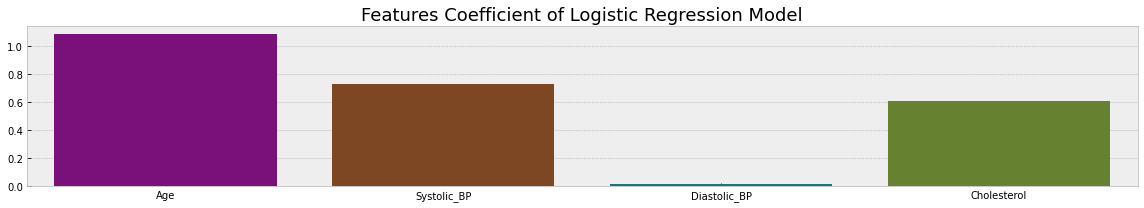

In [11]:
sns.barplot(x=[0, 1, 2, 3], y=model.coef_[0], zorder=2)
plt.xticks([0, 1, 2, 3], X.columns)
plt.title('Features Coefficient of Logistic Regression Model')
plt.tight_layout()
plt.show()

 The variables with the largest impact on the model's predictions are Age, systolic blood pressure, and cholesterol.

## Interaction terms

An interaction term is the product of two existing variables. When there is an interaction term, the effect of one variable that forms
the interaction depends on the level of the other variable in the interaction.

**Train**

In [12]:
features = X.columns
m = len(features)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X.columns)
X_train_int = X_train_transformed.copy()

for i in range(m):
    for j in range(i+1, m):
        feature_i_j_name = f"{features[i]}_x_{features[j]}"
        X_train_int[feature_i_j_name] = X_train_transformed.loc[:, features[i]] * X_train_transformed.loc[:, features[j]]

In [13]:
X_train_int.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol,Age_x_Systolic_BP,Age_x_Diastolic_BP,Age_x_Cholesterol,Systolic_BP_x_Diastolic_BP,Systolic_BP_x_Cholesterol,Diastolic_BP_x_Cholesterol
0,1.649443,1.221759,1.813002,0.532685,2.015222,2.990443,0.878634,2.215051,0.650813,0.965759
1,0.402037,-1.589339,-1.177166,-0.112640,-0.638973,-0.473264,-0.045286,1.870916,0.179023,0.132596
2,-0.913580,0.316431,0.353933,-0.504557,-0.289085,-0.323346,0.460953,0.111995,-0.159657,-0.178579
3,-0.310016,-0.518194,-1.206779,-1.147308,0.160649,0.374121,0.355684,0.625345,0.594528,1.384547
4,-1.249413,-0.623244,-0.170650,-1.062268,0.778689,0.213213,1.327211,0.106357,0.662053,0.181276


**Test**

In [14]:
features = X.columns
m = len(features)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=X.columns)
X_test_int = X_test_transformed.copy()

for i in range(m):
    for j in range(i+1, m):
        feature_i_j_name = f"{features[i]}_x_{features[j]}"
        X_test_int[feature_i_j_name] = X_test_transformed.loc[:, features[i]] * X_test_transformed.loc[:, features[j]]

**Model Using Interaction Terms**

In [15]:
model_int = LogisticRegression().fit(X_train_int, y_train)
y_pred_int = model_int.predict_proba(X_test_int)[:, 1] # Get probabilities of patients having the disease

In [16]:
print(f"C-index on test set with interaction variables: {cindex(y_test, y_pred_int):.4f}")

C-index on test set with interaction variables: 0.8293


The model with interaction terms performs slightly better than the model without interactions.

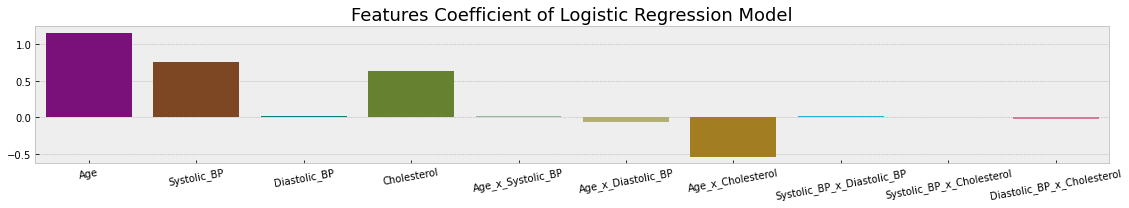

In [17]:
sns.barplot(x=np.arange(0, X_train_int.shape[1]), y=model_int.coef_[0], zorder=2)
plt.xticks(np.arange(0, X_train_int.shape[1]), X_train_int.columns, rotation=10)
plt.title('Features Coefficient of Logistic Regression Model')
plt.tight_layout()
plt.show()

Age, Systolic_BP, and Cholesterol have a positive coefficient, meaning that a higher value in these three features leads to a higher prediction probability for the disease. Also, the interaction of Age x Cholesterol has a negative coefficient, indicating that a higher value for the Age x Cholesterol product reduces the prediction probability for the disease.

The model is less confident in its prediction with the interaction term than without (the prediction value is lower when including the interaction term), as the model has adjusted for the fact that the effect of high cholesterol becomes less important for older patients compared to younger patients.

<div class='alert alert-info' style='font-size:2.3rem; font-weight:500; text-align:center;'>Risk Model Using Random Forest<div/>

The [NHANES I epidemiology data set](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx/) will be used. This data set contains various features of hospital patients as well as their outcomes, i.e. whether they died within 10 years.

A model will be built to predict the 10-year risk (probability) of death of individuals based on their features.

In [18]:
nhanes_df = pd.read_csv('utils/NHANES.csv')

In [19]:
print(f'Shape: {nhanes_df.shape}')
nhanes_df.head()

Shape: (8579, 19)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,Died in less than 10 years
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0,False
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0,False
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0,True
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0,False
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0,True


## Data Preparation

In [20]:
X = nhanes_df.drop(['Died in less than 10 years'], axis=1)
y = nhanes_df['Died in less than 10 years']

The dataset will be split into a development set used to develop risk models, and a test set used to test the models. The development set will be further split into a training and validation set, respectively to train and tune the models, using a 75/25 split.

In [21]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

**Create missing data for Systolic BP**

In [22]:
weights = np.array(1 - (np.exp(0.25 * X_dev['Age'] - 5) / (1 + np.exp(0.25 * X_dev['Age'] - 5))))
drop_rows_indexes = X_dev.sample(frac=0.7, replace=False, weights=weights, random_state=10).index
X_dev.loc[drop_rows_indexes, 'Systolic BP'] = None


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=10)

## Dealing with Missing Data

Missing data is a common occurrence in data analysis and can be due to a variety of reasons, such as measuring instrument malfunction, respondents not willing or not able to supply information, and errors in the data collection process. In general, missing data can be of three categories:

**Missing completely at random**: the events that lead to any particular data-item being missing are independent both of observable variables and of unobservable parameters of interest, and occur entirely at random. For this category, the analysis performed on the data is unbiased. It is the least frequent category.

**Missing at random**: the missingness is not random, but where missingness can be fully accounted for by variables where there is complete information. Depending on the analysis method, these data can still induce parameter bias in analyses due to the contingent emptiness of cells.

**Missing not at random**: the value of the variable that's missing is related to the reason it's missing.

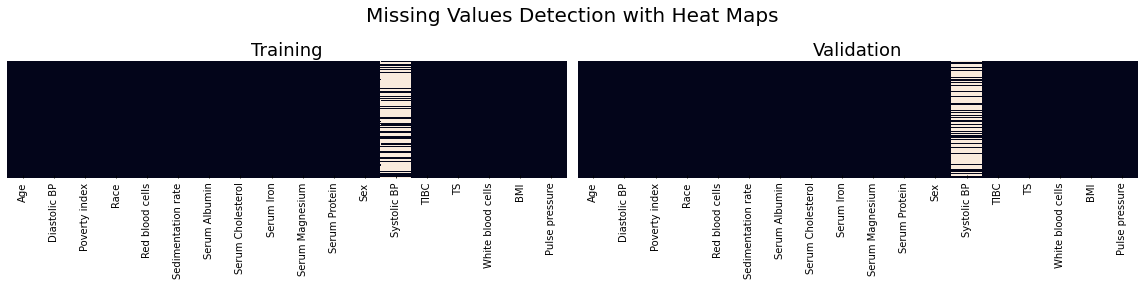

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=True)

sns.heatmap(X_train.isnull(), cbar=False, ax=axes[0])
axes[0].set_yticks([])
axes[0].set_title("Training")

sns.heatmap(X_val.isnull(), cbar=False, ax=axes[1])
axes[1].set_yticks([])
axes[1].set_title("Validation")

plt.suptitle('Missing Values Detection with Heat Maps', fontsize=20)
plt.tight_layout()
plt.show()

In [25]:
dropped_rows = X_train[X_train.isnull().any(axis=1)]
columns = [col for col in X_train.columns if col not in ['Systolic BP']]

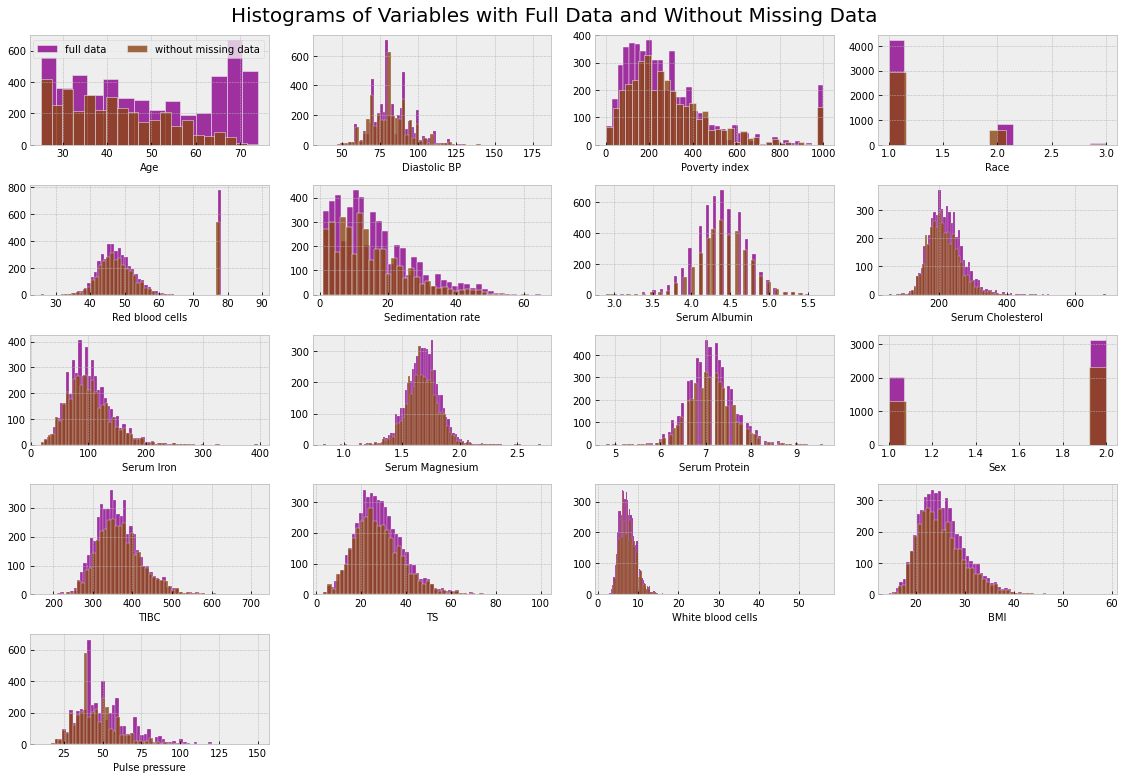

In [26]:
fig, axes = plt.subplots(5, 4, figsize=(16, 11))
axes = axes.flatten()

for ax, col in zip(axes, columns):
    
    sns.histplot(X_train.loc[:, col], kde=False, label='full data', color='darkmagenta', alpha=.8, ax=ax)
    sns.histplot(dropped_rows.loc[:, col], kde=False, label='without missing data', color='saddlebrown', alpha=.8, ax=ax)
    
    ax.set_ylabel('')
    if ax == axes[0]:
        ax.legend(ncol=2)

axes.flat[-1].set_visible(False)
axes.flat[-2].set_visible(False)
axes.flat[-3].set_visible(False)

plt.suptitle('Histograms of Variables with Full Data and Without Missing Data', fontsize=20)
plt.tight_layout()
plt.show()

Most of the variables are distributed similarly with and without missing values. If this had been true across all variables, then the data would have been said to be missing completely at random. However, the *age* variable presents a different distribution without missing values, as much more data tends to be missing for patients over 65. The reason could be that blood pressure was measured less frequently for old people to avoid placing additional burden on them. As missingness is related to one or more variables, the missing data is concluded  to be missing at random.

For a first analysis, the rows with missing values will be dropped.

In [27]:
X_dev_dropped = X_dev.dropna(axis='rows')
y_dev_dropped = y_dev.loc[X_dev_dropped.index]

X_train_dropped = X_train.dropna(axis='rows')
y_train_dropped = y_train.loc[X_train_dropped.index]

X_val_dropped = X_val.dropna(axis='rows')
y_val_dropped = y_val.loc[X_val_dropped.index]

In [28]:
print(f'Proportion of data set left after dropping: {X_train_dropped.shape[0] / X_train.shape[0]:.2%}')

Proportion of data set left after dropping: 30.13%


# Model: Random Forest

When applying a Decision Tree, overfitting is clearly present (Train C-Index: 1.0, Validation C-Index: 0.58). Even though some of the hyperparameters of the tree can be tuned, this algorithm is prone to overfitting. Therefore, a random forest will be preferred. By applying hyperparameter tuning via Cross-validation, it was found that the pair with higer c-index is 200 and 5.

In [29]:
rf_dropped = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=10)

rf_dropped.fit(X_train_dropped, y_train_dropped)

y_train_pred = rf_dropped.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped, y_train_pred)}")

y_val_pred = rf_dropped.predict_proba(X_val_dropped)[:, 1]
print(f"Validation C-Index: {cindex(y_val_dropped, y_val_pred):.2f}")

Train C-Index: 0.8613280163219883
Validation C-Index: 0.68


**Model evaluation on the test set**

In [30]:
y_test_pred = rf_dropped.predict_proba(X_test)[:, 1]

print(f"Test C-Index: {cindex(y_test, y_test_pred)}")

Test C-Index: 0.7097696299734189


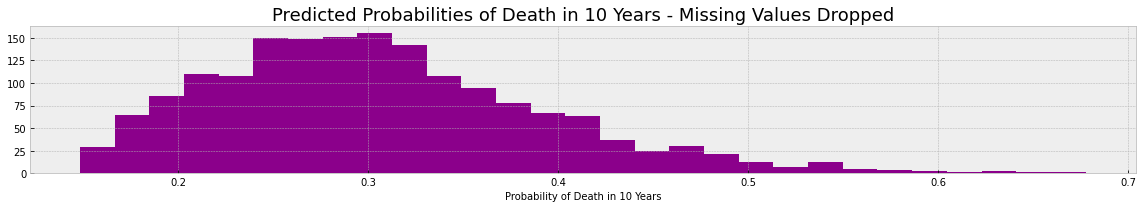

In [31]:
plt.hist(y_test_pred, bins='auto')
plt.xlabel('Probability of Death in 10 Years')
plt.title('Predicted Probabilities of Death in 10 Years - Missing Values Dropped')
plt.tight_layout()
plt.show()

## Imputation

Imputation is the process of replacing missing data with substituted values.

### Mean Substitution

This imputation technique consists on replacing any missing value with the mean of that variable for all other cases, whit the benefit of not changing the sample mean for that variable. However, mean imputation attenuates any correlations involving the variables that are imputed, as there is guaranteed to be no relationship between the imputed variable and any other measured variables.

In [32]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)
X_train_mean_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_mean_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

**Train**

In [33]:
rf_mean_imputed = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=10)

rf_mean_imputed.fit(X_train_mean_imputed, y_train)

y_train_pred = rf_mean_imputed.predict_proba(X_train_mean_imputed)[:, 1]
print(f"Train C-Index: {cindex(y_train, y_train_pred):.2f}")

y_val_pred = rf_mean_imputed.predict_proba(X_val_mean_imputed)[:, 1]
print(f"Validation C-Index: {cindex(y_val, y_val_pred):.2f}")

Train C-Index: 0.81
Validation C-Index: 0.75


**Model evaluation on the test set**

In [34]:
y_test_pred = rf_mean_imputed.predict_proba(X_test)[:, 1]

print(f"Test C-Index: {cindex(y_test, y_test_pred):.2f}")

Test C-Index: 0.78


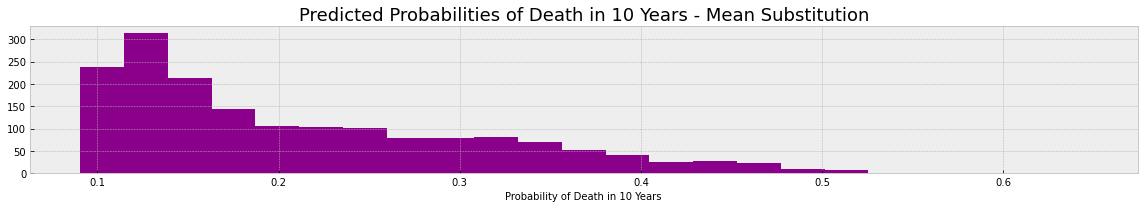

In [35]:
plt.hist(y_test_pred, bins='auto')
plt.xlabel('Probability of Death in 10 Years')
plt.title('Predicted Probabilities of Death in 10 Years - Mean Substitution')
plt.tight_layout()
plt.show()

### Regression or multivariate feature imputation

For each feature with missing values, a regression model is trained to predict observed values based on all of the other features, and the missing values are inferred using this model. As a single iteration across all features may not be enough to impute all missing values, several iterations may be performed.

In [36]:
imputer = IterativeImputer(random_state=2, sample_posterior=False, max_iter=10, min_value=0)
imputer.fit(X_train)
X_train_reg_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_reg_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

**Train**

In [37]:
rf_reg_imputed = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=10)

rf_reg_imputed.fit(X_train_reg_imputed, y_train)

y_train_pred = rf_reg_imputed.predict_proba(X_train_reg_imputed)[:, 1]
print(f"Train C-Index: {cindex(y_train, y_train_pred):.2f}")

y_val_pred = rf_reg_imputed.predict_proba(X_val_reg_imputed)[:, 1]
print(f"Validation C-Index: {cindex(y_val, y_val_pred):.2f}")

Train C-Index: 0.81
Validation C-Index: 0.75


**Model evaluation on the test set**

In [38]:
y_test_pred = rf_reg_imputed.predict_proba(X_test)[:, 1]

print(f"Test C-Index: {cindex(y_test, y_test_pred):.2f}")

Test C-Index: 0.78


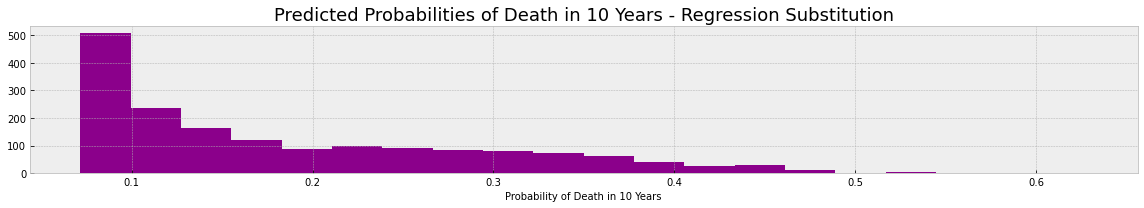

In [39]:
plt.hist(y_test_pred, bins='auto')
plt.xlabel('Probability of Death in 10 Years')
plt.title('Predicted Probabilities of Death in 10 Years - Regression Substitution')
plt.tight_layout()
plt.show()

## Model Interpretability with SHAP

SHAP (SHapley Additive exPlanations) is a cutting edge method that explains predictions made by black-box machine learning models. Given a prediction made by a machine learning model, SHAP values explain the prediction by quantifying the additive importance of each feature to the prediction. SHAP values have their roots in cooperative game theory, where Shapley values are used to quantify the contribution of each player to the game. Although it is computationally expensive to compute SHAP values for general black-box models, in the case of trees and forests there exists a fast polynomial-time algorithm ([TreeShap paper](https://arxiv.org/pdf/1802.03888.pdf)).

In [40]:
X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'risk'] = rf_reg_imputed.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='risk', ascending=False)
X_test_risk.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,risk
4302,67.0,80.0,30.0,1.0,77.7,59.0,3.4,231.0,36.0,1.40,6.3,1.0,170.0,202.0,17.8,8.4,17.029470,90.0,0.628334
2255,71.0,80.0,104.0,1.0,43.8,23.0,4.0,201.0,119.0,1.60,7.0,1.0,166.0,311.0,38.3,6.3,17.760766,86.0,0.537537
989,65.0,98.0,16.0,1.0,49.4,30.0,3.4,124.0,129.0,1.59,7.7,1.0,184.0,293.0,44.0,5.9,30.858853,86.0,0.530746
1811,66.0,100.0,69.0,2.0,42.9,47.0,3.8,233.0,170.0,1.42,8.6,1.0,180.0,411.0,41.4,7.2,22.129498,80.0,0.525877
5311,72.0,90.0,75.0,1.0,29.3,59.0,3.9,216.0,64.0,1.63,7.4,2.0,182.0,322.0,19.9,9.3,22.281793,92.0,0.522734


### Force plot

They are useful for understanding the model output on specific individuals.

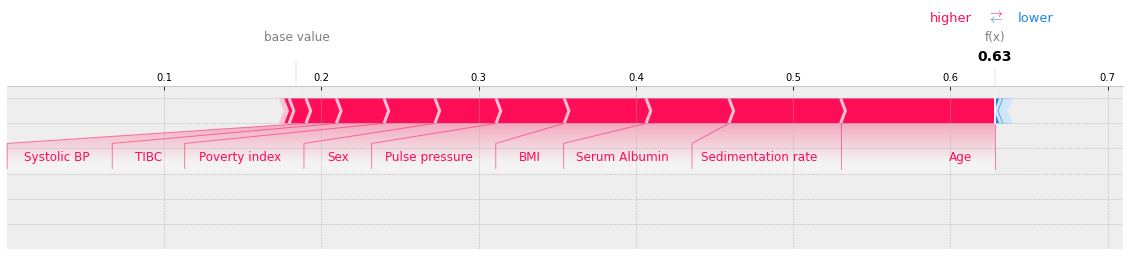

In [41]:
explainer = shap.TreeExplainer(rf_reg_imputed)
i = 0
shap_value = explainer.shap_values(X_test.loc[X_test_risk.index[i]])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

The red sections on the left are features which push the model towards the final prediction in the positive direction (i.e. a higher Age increases the predicted risk). The blue sections on the right are features that push the model towards the final prediction in the negative direction (if an increase in a feature leads to a lower risk, it will be shown in blue). The exact output of the chart will differ depending on the hyper-parameters chosen for the model.

### Summary plot

Useful to understand the model output in aggregate and to see a summary plot of the SHAP values for each feature on each of the test examples. The colors indicate the value of the feature.

In [42]:
shap_values = shap.TreeExplainer(rf_reg_imputed).shap_values(X_test)[1]

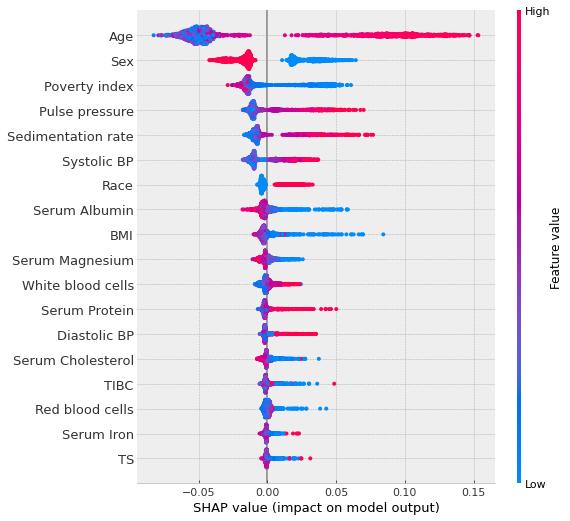

In [43]:
shap.summary_plot(shap_values, X_test)

It can be seen that being a woman has a negative SHAP value, meaning that it reduces the risk of dying within 10 years. High age and high systolic blood pressure have positive SHAP values, and are therefore related to increased mortality. 

### Dependence plot

It is useful to see how features interact. They plot the SHAP value for a given feature for each data point, and color the points using the value for another feature, to help explain the variation in SHAP value for a single value of the main feature.

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


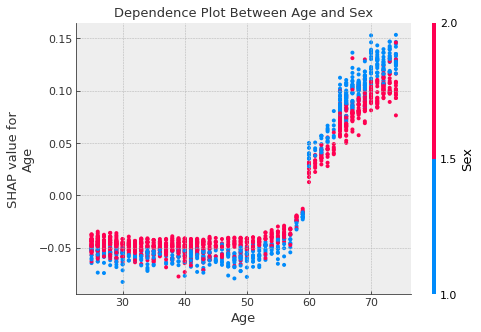

In [44]:
shap.dependence_plot(ind='Age', shap_values=shap_values, features=X_test, interaction_index='Sex', title='Dependence Plot Between Age and Sex')

It can be seen that while an Age greater than 50 is generally bad (positive SHAP value), being a woman generally reduces the impact of age. This makes sense since we know that women generally live longer than men.

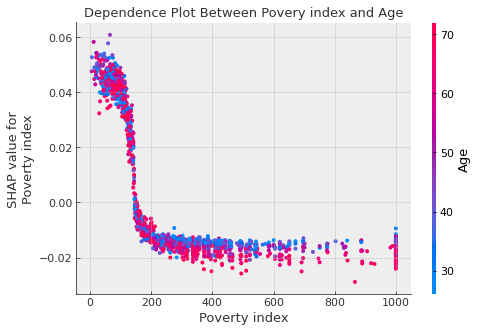

In [45]:
shap.dependence_plot(ind='Poverty index', shap_values=shap_values, features=X_test, interaction_index='Age', title='Dependence Plot Between Povery index and Age')

It can be seen that the impact of poverty index drops off quickly, and for higher income individuals age begins to explain much of variation in the impact of poverty index.

<div class='alert alert-info' style='font-size:2.3rem; font-weight:500; text-align:center;'>Survival Estimates that Vary with Time<div/>

## Survival Analysis

Survival analysis is a branch of statistics for analyzing the expected duration of time until one event occurs, such as death in biological organisms and failure in mechanical systems. Survival analysis attempts to answer certain questions, such as

* What is the proportion of a population which will survive past a certain time? 
* Of those that survive, at what rate will they die or fail?
* Can multiple causes of death or failure be taken into account?
* How do particular circumstances or characteristics increase or decrease the probability of survival?

The object of primary interest is the survival function $S$, defined as

$$S(t) = Pr(T > t)$$

where $t$ is some time and $T$ is a random variable denoting the time of death. In words, the survival function is the probability that the time of death is later than some specified time. $S(0) = 1$ is usually assumed. The survival function must be non-increasing, reflecting the notion that survival to a later age is possible only if all younger ages are attained, and $S(t) \to 0$ as $t \to \infty$.

## Censoring

Censoring is a condition in which the value of a measurement or observation is only partially known. In this case, censorship means that the observation has ended without any observed event. For example, let a patient be in a hospital for 100 days at most. If a patient dies after only 44 days, their event will be recorded as `Time = 44` and `Event = 1`. If a patient walks out after 100 days and dies 3 days later (103 days total), this event is not observed and the corresponding row has `Time = 100` and `Event = 0`. If a patient survives for 25 years after being admitted, their data are still `Time = 100` and `Event = 0`.

Types of censoring include

* **Left censoring**: a data point is below a certain value but it is unknown by how much.
* **Interval censoring**: a data point is somewhere on an interval between two values.
* **Right censoring**: a data point is above a certain value but it is unknown by how much.

## Data set

The following [data](https://www.statsdirect.com/help/content/survival_analysis/logrank.htm) represent the survival in days since entry to the trial of patients with diffuse histiocytic lymphoma, i.e. cancer of the lymphatic system. 

Two different groups of patients, those with stage III and those with stage IV disease, are compared. *Time* states the days the patient lived before they died or were censored, while *Censor* indicates whether a death was observed (1) or not (0).

The Kaplan-Meier model will be used to estimate the survival function for for lymphoma patients.

In [46]:
lymphoma_df = load_lymphoma()
lymphoma_df

,Stage_group,Time,Censor
0,1,6,1
1,1,19,1
2,1,32,1
3,1,42,1
4,1,42,1
...,...,...,...
75,2,291,0
76,2,302,0
77,2,304,0
78,2,341,0


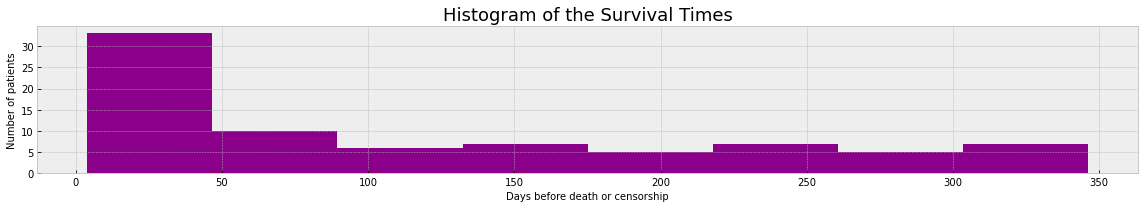

In [47]:
lymphoma_df['Time'].hist(bins='auto')
plt.title('Histogram of the Survival Times')
plt.xlabel("Days before death or censorship")
plt.ylabel("Number of patients")
plt.tight_layout()
plt.show()

In [48]:
censored_proportion = (lymphoma_df['Censor'] == 0).sum() / len(lymphoma_df)
print(f'{censored_proportion:.2%} of the data is censored')

32.50% of the data is censored


## Kaplan-Meier Estimator

The Kaplan-Meier Estimator is a non-parametric statistic used to estimate the survival function from lifetime data. In medical research, it is often used to measure the fraction of patients living for a certain amount of time after treatment. The estimator is named after Edward L. Kaplan and Paul Meier, who each submitted similar manuscripts to the Journal of the American Statistical Association, and combined their work in the 1958 publication [Estimation from Incomplete Observations](https://web.stanford.edu/~lutian/coursepdf/KMpaper.pdf).

The estimator of the survival function is given by

$$S(t) = \prod_{t_i \leq t} (1 - \frac{d_i}{n_i})$$

where

* $t_i$ are the event times observed in the data set.
* $d_i$ is the number of deaths at time $t_i$.
* $n_i$ is the number of people who are known to have survived up to time $t_i$.

The survival functions for both stage groups will be analyzed in what is called **Subgroup Analysis**. Group 1 corresponds to patients with stage III cancer, and group 2 corresponds to patients with stage IV cancer.

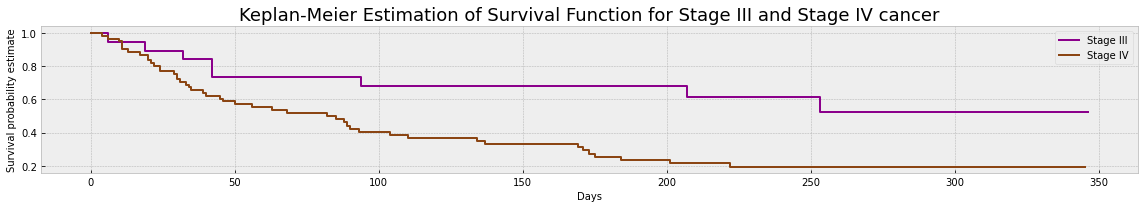

In [49]:
stage_group_1 = lymphoma_df[lymphoma_df['Stage_group'] == 1]
km1 = KaplanMeierFitter().fit(stage_group_1['Time'], event_observed=stage_group_1['Censor'], label='Stage III')

stage_group_2 = lymphoma_df[lymphoma_df['Stage_group'] == 2]
km2 = KaplanMeierFitter().fit(stage_group_2["Time"], event_observed=stage_group_2['Censor'], label='Stage IV')

km1.plot(ci_show=False)
km2.plot(ci_show=False)
plt.xlabel('Days')
plt.ylabel('Survival probability estimate')
plt.title('Keplan-Meier Estimation of Survival Function for Stage III and Stage IV cancer')

plt.tight_layout()
plt.show()

A clear difference in survival probability can be seen between the Stage III and IV cancer groups. However, to conclude whether there is a statistical difference between the survival curves, the log-rank test will be applied. 

## Logrank test

The logrank test compares the survival distribution of two samples under the null hypothesis that there is no difference in survival between two or more independent groups.

In [50]:
test = logrank_test(durations_A=stage_group_1['Time'],
                       durations_B=stage_group_2['Time'], 
                       event_observed_A=stage_group_1['Censor'],
                       event_observed_B=stage_group_2['Censor'])

if test.p_value < 0.05:
    print('Null Hypothesis rejected: the difference in survival between Stage III and Stage IV groups is statistically significant.')

Null Hypothesis rejected: the difference in survival between Stage III and Stage IV groups is statistically significant.


<div class='alert alert-info' style='font-size:2.2rem; font-weight:500; text-align:center;'>Cox Proportional Hazards and Random Survival Forests<div/>

The data set of [PBC](https://www4.stat.ncsu.edu/~boos/var.select/pbc.html) consists of survival data of patients with Primary Biliary Cirrhosis (PBC), a progressive disease of the liver caused by a buildup of bile within the liver (cholestasis) that results in damage to the small bile ducts that drain bile from the liver. 

The data set consists of the following features:

* **id**: case number
* **time**: number of years between registration and the earlier of death, transplantion, or study analysis time in July, 1986
* **status**: 0=alive, 1=liver transplant, 2=dead
* **drug**: 1= D-penicillamine, 2=placebo
* **age**: age in days
* **sex**: 0=male, 1=female
* **ascites**: presence of ascites: 0=no 1=yes
* **hepato**: presence of hepatomegaly 0=no 1=yes
* **spiders**: presence of spiders 0=no 1=yes
* **edema**: presence of edema 0=no edema and no diuretic therapy for edema; .5 = edema present without diuretics, or edema resolved by diuretics; 1 = edema despite diuretic therapy
* **bili**: serum bilirubin in mg/dl
* **chol**: serum cholesterol in mg/dl
* **albumin**: albumin in gm/dl
* **copper**: urine copper in ug/day
* **alk_phos**: alkaline phosphatase in U/liter
* **sgot**: SGOT in U/ml
* **trig**: triglicerides in mg/dl
* **platelet**: platelets per cubic ml/1000
* **protime**: prothrombin time in seconds
* **stage**: histologic stage of disease

In this work, risk models using survival data and a combination of linear and non-linear techniques will be built to understand the effects of different factors on the survival times of the patients.

In [51]:
pbc_df = pd.read_csv('utils/pbc.csv')

In [52]:
print(f'Shape: {pbc_df.shape}')
pbc_df.head()

Shape: (258, 19)


,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
0,1.095890,1.0,0.0,58.765229,0.0,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,12.328767,0.0,0.0,56.446270,0.0,0.0,1.0,1.0,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,2.772603,1.0,0.0,70.072553,1.0,0.0,0.0,0.0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,5.273973,1.0,0.0,54.740589,0.0,0.0,1.0,1.0,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5.019178,0.0,1.0,55.534565,0.0,0.0,1.0,0.0,0.0,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0


# Data Preparation

**Dev - Train - Test split**

In [53]:
df_dev, df_test = train_test_split(pbc_df, test_size = 0.2, random_state=0)
df_train, df_val = train_test_split(df_dev, test_size = 0.25, random_state=0)

**Standardization**

In [54]:
continuous_columns = ['age', 'bili', 'chol', 'albumin', 'copper', 'alk.phos', 'ast', 'trig', 'platelet', 'protime']

mean = df_train[continuous_columns].mean()
std = df_train[continuous_columns].std()

df_train[continuous_columns] = (df_train[continuous_columns] - mean) / std
df_val[continuous_columns] = (df_val[continuous_columns] - mean) / std
df_test[continuous_columns] = (df_test[continuous_columns] - mean) / std


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**One-Hot Encoding**

In [55]:
one_hot_train = pd.get_dummies(df_train, columns=['edema', 'stage'], drop_first=True)
one_hot_val = pd.get_dummies(df_val, columns=['edema', 'stage'], drop_first=True)
one_hot_test = pd.get_dummies(df_test, columns=['edema', 'stage'], drop_first=True)

## Cox Proportional Hazards

In medicine, a hazard is defined as a factor or exposure that may adversely affect health, anything that has the potential to cause harm.

Proportional hazards models are a class of survival models, in which the unique effect of a unit increase in a variable is multiplicative with respect to the hazard rate. The Cox Proportional Hazards model was introduced by David Cox in the 1972 paper [Regression Models and Life-Tables](https://rss.onlinelibrary.wiley.com/doi/pdfdirect/10.1111/j.2517-6161.1972.tb00899.x). The model describes the hazard $\lambda$ for an individual $i$ at time $t$ as 

$$\lambda(t, x) = \lambda_0(t)e^{\theta^T X_i}$$

where $\lambda_0$ is a baseline hazard and incorporates the risk over time, and the other term incorporates the risk due to the individual's variables. After fitting the model, individuals can be ranked using the person-dependent risk term $e^{\theta^T X_i}$. 

In [56]:
cox_proportional_hazard_model = CoxPHFitter().fit(one_hot_train, duration_col='time', event_col='status', step_size=0.1)

Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.793. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?



In [57]:
cox_proportional_hazard_model.print_summary()

<lifelines.CoxPHFitter: fitted with 154 total observations, 91 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 154
number of events observed = 63
   partial log-likelihood = -222.51
         time fit was run = 2021-08-01 20:33:17 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
trt        -0.33       0.72       0.32            -0.96             0.31                 0.38                 1.36
age        -0.02       0.98       0.18            -0.38             0.34                 0.69                 1.40
sex         1.05       2.87       0.44             0.19             1.91                 1.21                 6.78
ascites    -0.46       0.63       0.57            -1.59             0.66                 0.20                 1.94
hepato      0.66       1.93       0.40            -0.13             1.44                 0.88                 4.24
spiders    -0.19       0.83       0.41            -0.99             0.61                 0.37                 1.83
bili        0.13       1.14       0.18            -0.22             0.48                 0.80                 1.62
chol        0.29       1.33       0.14             0.01             0.56                 1.02                 1.74
albumin    -0.49       0.62       0.16            -0.80            -0.17                 0.45                 0.84
copper      0.18       1.20       0.16            -0.14             0.50                 0.87                 1.65
alk.phos   -0.24       0.79       0.14            -0.52             0.04                 0.59                 1.05
ast         0.51       1.66       0.17             0.18             0.84                 1.20                 2.31
trig        0.20       1.22       0.16            -0.12             0.52                 0.89                 1.68
platelet    0.17       1.19       0.16            -0.14             0.48                 0.87                 1.61
protime     0.50       1.65       0.17             0.16             0.84                 1.17                 2.31
edema_0.5   0.95       2.59       0.46             0.05             1.86                 1.05                 6.39
edema_1.0   1.59       4.88       0.61             0.39             2.78                 1.48                16.13
stage_2.0  17.35   3.43e+07    2423.49         -4732.61          4767.31                 0.00                  inf
stage_3.0  16.84   2.06e+07    2423.49         -4733.12          4766.80                 0.00                  inf
stage_4.0  17.63   4.53e+07    2423.49         -4732.33          4767.59                 0.00                  inf

              z      p   -log2(p)
covariate                        
trt       -1.01   0.31       1.68
age       -0.11   0.91       0.13
sex        2.39   0.02       5.91
ascites   -0.80   0.42       1.24
hepato     1.63   0.10       3.28
spiders   -0.47   0.64       0.64
bili       0.73   0.46       1.10
chol       2.07   0.04       4.69
albumin   -3.06 <0.005       8.82
copper     1.13   0.26       1.94
alk.phos  -1.65   0.10       3.35
ast        3.03 <0.005       8.68
trig       1.23   0.22       2.19
platelet   1.09   0.28       1.85
protime    2.88 <0.005       7.95
edema_0.5  2.07   0.04       4.70
edema_1.0  2.60   0.01       6.75
stage_2.0  0.01   0.99       0.01
stage_3.0  0.01   0.99       0.01
stage_4.0  0.01   0.99       0.01
---
Concordance = 0.84
Partial AIC = 485.02
log-likelihood ratio test = 114.70 on 20 df
-log2(p) of ll-ratio test = 48.39

According to the model, the treatment (trt) was beneficial because it has a negative impact on the hazard (the coefficient is negative, and exp(coef) is less than 1). The hazard ration (how much an incremental increase in the feature variable changes the hazard), is exp(coef) = 0.72.

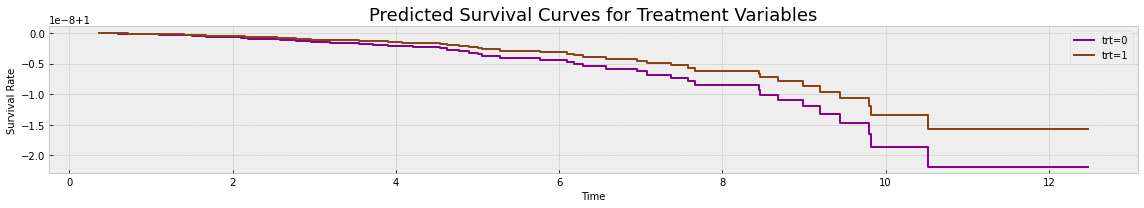

In [59]:
cox_proportional_hazard_model.plot_partial_effects_on_outcome('trt', values=[0, 1], plot_baseline=False)
plt.xlabel('Time')
plt.ylabel('Survival Rate')
plt.title('Predicted Survival Curves for Treatment Variables')
plt.tight_layout()
plt.show()

It can be noticed how the group without treatment has a lower survival rate at all times compared to the treatment group.

## Hazard Ratio

The Hazard Ratio between two patients was the likelihood of one patient (e.g smoker) being more at risk than the other (e.g non-smoker).

$$ \frac{\lambda_{smoker}(t)}{\lambda_{nonsmoker}(t)} = e^{\theta (X_{smoker} - X_{nonsmoker})^T} $$

Where $\lambda_{smoker}(t) = \lambda_0(t)e^{\theta X_{smoker}^T} \quad$ and $ \quad\lambda_{nonsmoker}(t) = \lambda_0(t)e^{\theta X_{nonsmoker}^T}$

For example, to evaluate which individual in a pair is at greatest risk, the hazard ratio is computed. 

In [60]:
individual_1 = one_hot_train.iloc[4, :].drop(['time', 'status'])
individual_2 = one_hot_train.iloc[7, :].drop(['time', 'status'])

hazard_ratio = np.exp(cox_proportional_hazard_model.params_.values.dot((individual_1 - individual_2).T))
   
print(f'Hazard Ratio: {hazard_ratio:.2f}')

Hazard Ratio: 0.03


Individual 2 is at higher risk, as the hazard ratio of individual 1/individual 2 is less than 1, so individual 2 had a higher hazard relative to individual 1.

## Harrell's C-index

C-index in the survival context is the probability that given a randomly selected pair of individuals the one who died sooner has a higher risk score. However, now censoring must be taken into account. Let $A$ and $B$ be a pair of patients. 

If A was censored at time $t_A$, B died at $t_B$, and $t_A < t_B$, it cannot be said whether $A$ or $B$ should have a higher risk score. However, if A was censored at time $t_A$, B died at $t_B$, and $t_A > t_B$, it can be said that $B$ should have a higher risk score than $A$, since it is known that $A$ lived longer.

Therefore, when we compute our C-index, only pairs where at most one person is censored must be considered, and, if they are censored, then their censored time should occur *after* the other person's time of death. 

The metric got when following this rule is called **Harrel's C-index**.

In this case, being censored at time $t$ means that the true death time was some time after time $t$, and not at $t$.

In [61]:
def harrell_c(y_true, y_pred, event):
    
    n = len(y_true)

    concordant = 0
    permissible = 0
    ties = 0
    
    for i in range(n):
        for j in range(i+1, n):
            
            # check if at most one is censored
            if event[i] == 1 or event[j] == 1:
            
                # check if neither are censored
                if event[i] == 1 and event[j] == 1:
                    
                    permissible += 1.0
                    
                    # check if y_pred are tied
                    if y_pred[i] == y_pred[j]:
                        ties += 1.0
                    
                    # check for concordant
                    elif y_true[i] < y_true[j] and y_pred[i] > y_pred[j]:
                        concordant += 1.0
                    elif y_true[i] > y_true[j] and y_pred[i] < y_pred[j]:
                        concordant += 1.0
                
                # check if one is censored
                elif event[i] != event[j]:
                    
                    # get censored index
                    censored = j
                    uncensored = i
                    
                    if event[i] == 0:
                        censored = i
                        uncensored = j
                        
                    if y_true[uncensored] <= y_true[censored]:
                        permissible += 1.0
                        
                        # check if y_pred are tied
                        if y_pred[uncensored] == y_pred[censored]:
                            # update ties 
                            ties += 1.0
                            
                        # check if y_pred are concordant 
                        if y_pred[uncensored] > y_pred[censored]:
                            concordant += 1.0
    
    result = (concordant + 0.5*ties) / permissible
    
    return result   

In [62]:
# Train
y_pred = cox_proportional_hazard_model.predict_partial_hazard(one_hot_train)
cox_train_y_pred = harrell_c(one_hot_train['time'].values, y_pred.values, one_hot_train['status'].values)

y_pred = cox_proportional_hazard_model.predict_partial_hazard(one_hot_val)
cox_val_y_pred = harrell_c(one_hot_val['time'].values, y_pred.values, one_hot_val['status'].values)

y_pred = cox_proportional_hazard_model.predict_partial_hazard(one_hot_test)
cox_test_y_pred = harrell_c(one_hot_test['time'].values, y_pred.values, one_hot_test['status'].values)

print(f'Train C-Index {cox_train_y_pred:.2f}')
print(f'Val C-Index {cox_val_y_pred:.2f}')
print(f'Test C-Index {cox_test_y_pred:.2f}')

Train C-Index 0.84
Val C-Index 0.78
Test C-Index 0.81


<div class='alert alert-info' style='font-size:2.2rem; font-weight:500; text-align:center;'>References<div/>

[AI For Medical Prognosis](https://www.coursera.org/learn/ai-for-medical-prognosis)